In [20]:
import io
import traceback
import pandas as pd
from connections import AWS
from biomech.algorithms import butter_lowpass_filter

In [2]:
""" INITIALIZE AWS CONNECTION """
aws_connection = AWS()
aws_connection.connect()

[AWS]: Port 5433 is free.
[AWS]: Connected to RDS endpoint.


$\textbf{OpenSim Joint Reaction Analysis: Postprocessing}$

- Aggregate all _elbow varus torque_ results files
- Create spaghetti plots
- Evaluate peaks for each trial & inspect for outliers

In [4]:
from jra_functions import get_trial_peaks, inspect_subject_results

In [5]:
# load all subject info
subject_info = aws_connection.load_subject_info()

# load all processed JRA files --> 3,650 total to start
s3_objects = aws_connection.list_s3_objects(prefix='biomechanics/subjects/')
jra_files = [obj for obj in s3_objects if obj.endswith('.sto') and 'jra_evt' in obj]

In [ ]:
# initialize JRA peak results
error_log = []
all_trials = []
all_peaks = []

# iterate through subjects
    # NOTE: doing this to streamline outlier detection
for subject_id in subject_info['subject_id'].unique():
    
    # ignore 3056 for now
    if subject_id == 3056:
        continue
    
    print(f'Processing subject {subject_id}...', end='\r', flush=True)
    
    # filter JRA files for this subject, initialize list of peaks
    subject_jra_files = [f for f in jra_files if str(subject_id) in f]
    subject_jra_peaks = []

    if len(subject_jra_files) == 0:
        print(f'No JRA files found for subject {subject_id}. Skipping...')
        continue
    
    # iterate through subject files
    for f in subject_jra_files:
        try:
            # extract subject ID, study ID, and throwing hand
            study_id = f.split('/')[-1].split('_jra')[0]
            subject_id = study_id.split('_')[0]
            throwing_hand = subject_info.loc[subject_info['subject_id'] == int(subject_id), 'throws'].values[0]

            # load JRA results file
            trial_evt_bytes = aws_connection.load_s3_object(f)
            trial_evt_data = pd.read_csv(io.BytesIO(trial_evt_bytes))

            # append to all_trials w/ study_id inserted
            trial_evt_data.insert(0, 'study_id', study_id)
            all_trials.append(trial_evt_data)

            # evaluate peaks for this trial
            trial_peaks = get_trial_peaks(trial_evt_data)
            subject_jra_peaks.append(trial_peaks)
       
        except Exception as e:
            traceback.print_exc()
            error_log.append({
                'study_id': study_id,
                'error': str(e)
            })
            print(f'Error processing {f}: {e}')
            
            continue
    
    try:
        # evaluate subject results
        subject_peaks_df = pd.DataFrame(subject_jra_peaks)
        evaluated_subject_peaks = inspect_subject_results(subject_peaks_df)

        # append to all_peaks
        evaluated_subject_peaks.insert(0, 'subject_id', subject_id)
        all_peaks.append(evaluated_subject_peaks)

    except Exception as e:
        traceback.print_exc()
        error_log.append({
            'subject_id': subject_id,
            'error': str(e)
        })
        print(f'Error evaluating subject {subject_id}: {e}')
        
        continue

print('All subjects processed succesfully.')

# concatenate all trials and peaks
all_trials = pd.concat(all_trials, ignore_index=True)
all_peaks = pd.concat(all_peaks, ignore_index=True)

Traceback (most recent call last):
  File "/var/folders/tp/v0pnyp7d2v53cm631gtft6b80000gp/T/ipykernel_50748/1130789023.py", line 41, in <module>
    trial_peaks = get_trial_peaks(trial_evt_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cmoore/Library/Mobile Documents/com~apple~CloudDocs/Human RITHM/GitHub/pitch-ml/prod/biomech/joint_reaction_analysis/jra_functions.py", line 369, in get_trial_peaks
    'study_id': data['study_id'].unique()[0],
                ~~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: index 0 is out of bounds for axis 0 with size 0


Error processing biomechanics/subjects/2611/jra/2611_13_jra_evt.sto: index 0 is out of bounds for axis 0 with size 0
No JRA files found for subject 2670. Skipping...


In [50]:
# upload all peaks and trials to DB
aws_connection.upload_to_s3(
    all_trials, 
    'biomechanics/subjects/summary/jra_trials_all.csv'
)
aws_connection.upload_to_s3(
    all_peaks, 
    'biomechanics/subjects/summary/jra_peaks_all.csv'
)

[AWS]: Uploaded object to s3://pitch-ml/biomechanics/subjects/summary/jra_trials_all.csv
[AWS]: Uploaded object to s3://pitch-ml/biomechanics/subjects/summary/jra_peaks_all.csv


$\textbf{Plotting}$

- Spaghetti Plots (EVT vs. Normalized Time)

In [36]:
import matplotlib.pyplot as plt

In [37]:
# join trials with peaks on study_id
trials_w_metadata = all_trials.merge(all_peaks, on=['study_id'], how='left')

In [ ]:
# TODO: plot separately by pitcher to determine the noise source(s)? 

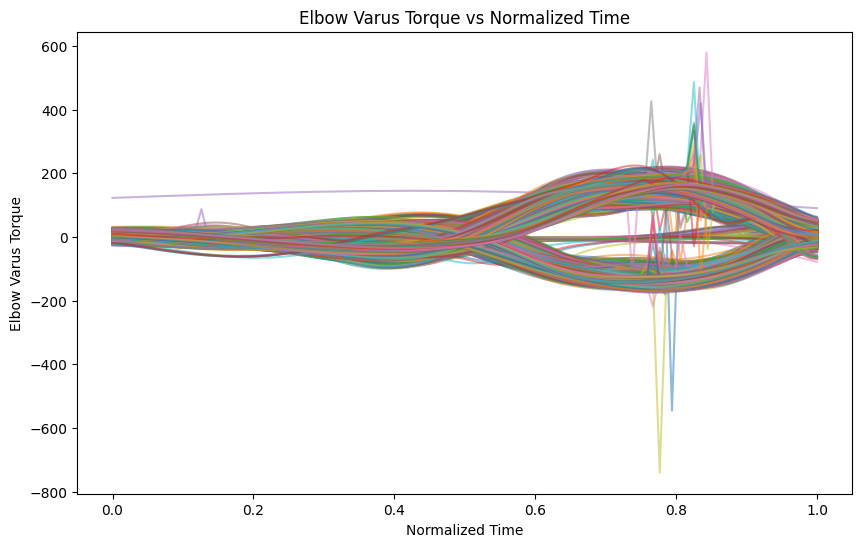

In [38]:
# create figure
plt.figure(figsize=(10, 6))

# add traces to plot
for study_id, group in trials_w_metadata[trials_w_metadata['outlier_flag'] == 0].groupby('study_id'):
    plt.plot(group['normalized_time'], group['elbow_varus_torque'], alpha=0.5, label=study_id)

# add details
plt.xlabel('Normalized Time')
plt.ylabel('Elbow Varus Torque')
plt.title('Elbow Varus Torque vs Normalized Time')
plt.legend([],[], frameon=False)
plt.show()

$\textbf{Close AWS Connection}$

In [51]:
aws_connection.close()

[AWS]: No active connection to close.
